In [2]:
import gensim
import random
import itertools
from math import exp, log2
from sklearn.utils.extmath import softmax
from gensim.models.keyedvectors import KeyedVectors
from Levenshtein import distance as levenshtein_distance
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
model = KeyedVectors.load_word2vec_format('model_prime.txt')

In [234]:
PROFITS = {
    'r': 1,
    'b': -1.5,
    'd': -1000,
    'w': -0.7
}

In [235]:
class Word:
    def __init__(self):
        self.word = ''
        self.marker = ''
    
    def __init__(self, s, marker=''):
        self.word = s.lower().replace('\xad', '').replace('ё', 'е')
        self.marker = marker
    
    def __repr__(self):
        return self.word + '_' + self.marker
    
    def make_random(self):
        self.cnt = 0
        self.dict = {}
    
    def calc_profit(self):
        self.profit = 0
        if self.cnt == 0:
            return
        for a, b in PROFITS.items():
            if not a in self.dict:
                self.dict[a] = 0
            self.profit += (self.dict[a] / self.cnt) * b

In [236]:
class Field:
    def __init__(self):
        self.current = 0
        self.n = 25
        self.all = []
    
    def __iter__(self):
        self.current = 0
        return self
    
    def __next__(self):
        if self.current == self.n:
            raise StopIteration
        result = self.all[self.current]
        self.current += 1
        return result

    def __len__(self):
        return len(self.all)
    
    def gen(self):
        with open('words.txt') as f:
            wordlist = f.readline().split()
            wordlist = [x for x in wordlist]
            markers = ['r'] * 9 + ['b'] * 8 + ['d'] * 1 + ['w'] * 7
            self.all = [Word(x, y) for x, y in zip(random.sample(wordlist, self.n), markers)]
    
    def __repr__(self):
        res = ''
        for s in self:
            res += str(s) + '\n'
        return res

In [272]:
x = Field()
x.gen()

In [238]:
def similar_list(wordlist):
    if len(wordlist) == 0:
        return []
    return model.most_similar(positive=wordlist)

In [239]:
LEVENSHTEIN_THRESHOLD = 4
SIMILARITY_THRESHOLD = 0.55
def filtered_similars(wordlist):
    unfiltered = similar_list(wordlist)
    result = []
    for s, dist in unfiltered:
        ok = True
        for parent in wordlist:
            if levenshtein_distance(parent, s) <= LEVENSHTEIN_THRESHOLD or parent in s:
                ok = False
        if ok:
            result.append((s, dist))
    return result

In [240]:
def query(wordlist):
    return filtered_similars(wordlist)

In [241]:
def find_candidates(field, marker='r'):
    good_words = [x.word for x in field if x.marker == marker]
    result = set()
    for i in range(2, len(good_words)):
        for lists in [query(_) for _ in list(itertools.combinations(good_words, i + 1))]:
            for value in lists:
                result.add(value[0])
    return result

In [242]:
def scaling(x):
    return x # exp(x * 10)

In [243]:
CAN_GUESS_THRESHOLD = 0.3
def guess(field, word, top_n=-1):
    pairs = []
    random_word = Word('', 'random')
    random_word.make_random()
    for item in field:
        if 'u' in item.marker:
            continue
        val = scaling(model.similarity(word, item.word))
        if val > CAN_GUESS_THRESHOLD:
            pairs.append((val, item))
        else:
            random_word.cnt += 1
            if not item.marker in random_word.dict:
                random_word.dict[item.marker] = 0
            random_word.dict[item.marker] += 1
    random_word.calc_profit()
    if top_n != -1:
        result = [(b, a) for a, b in sorted(pairs)[::-1]]
        while len(result) < top_n:
            result.append((random_word, 0))
        return result[:top_n]
    else:
        return pairs

In [244]:
def calc_profit(wordlist, marker):
    result = 0
    current_iter = 1
    for x in wordlist:
        if x.marker == 'random':
            result += x.profit / log2(current_iter + 1)
        else:
            result += PROFITS[x.marker] / log2(current_iter + 1)
        current_iter += 1
    return result

In [245]:
def bruteforce(field, marker):
    candidates = find_candidates(field, marker)
    all_moves = []
    for number in range(1, len(field) + 1):
        for word in candidates:
            wordlist = [x for x, _ in guess(field, word, number)]
            all_moves.append((calc_profit(wordlist, marker), (word, number), wordlist))
    return sorted(all_moves)[::-1]

In [246]:
def do_move(field):
    return bruteforce(field, 'r')[0][1]

In [247]:
def do_guess(field, word):
    sorted_list = guess(field, word)
    return sorted_list[0][1]

In [248]:
def do_clear(field, word):
    for i, w in enumerate(field):
        if w.word == word:
            field.all[i].marker += '_u'
            return

### ================== here is the bullshit line ===========================

In [249]:
for s in x.all:
    print(s.word, [x[0] for x in query([s.word])])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


лад ['тональность', 'унисон', 'переиначивать', 'настраивый', 'мажорный', 'настрой']
мир ['https://new.vk.com/club31377748']
америка ['канада', 'сша', 'англия', 'европа', 'корея', 'куба', 'британия', 'бразилия']
стадион ['лужники', 'спорткомплекс', 'ипподром', 'футбольный', 'болельщик', 'спортплощадка', 'баскетбольный', 'фан-зона', 'велотрек', 'корт']
баня ['парилка', 'попариться', 'мыться', 'купальня']
высота ['вершина', 'ширина', 'фут', 'верхотура', 'расстояние']
глаз ['гектлазар']
коса ['заплести', 'заплетать', 'расчесав', 'прядь']
панель ['приборный', 'дисплей', 'кнопка', 'щиток', 'монитор', 'тумблер']
дробь ['барабанный', 'чечетка', 'картечь', 'постукивание', 'перестук', 'выстукивать', 'морзянка']
прибор ['аппаратура', 'датчик', 'сканнер', 'анализатор', 'измерительный', 'оборудование', 'агрегат', 'эхолот']
эфир ['трансляция', 'телеканал', 'телевидение', 'радиоканал', 'транслировать', 'прайм-тайм']
точка ['зрение', 'отправный', 'отправной', 'реперный', '-лун']
кулак ['костяшка', 'сж

In [250]:
model.similarity('уточка', 'утка')

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.7408302

In [251]:
levenshtein_distance('a', 'b')

1

In [252]:
levenshtein_distance('ab', 'bab')

1

In [253]:
levenshtein_distance('bac', 'cab')

2

In [254]:
query(['карта', 'двигатель'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('движок', 0.6690325736999512),
 ('мотор', 0.6228243112564087),
 ('навигатор', 0.6082278490066528),
 ('турбина', 0.5876405239105225),
 ('движка', 0.5636513233184814),
 ('навигационный', 0.5631181001663208)]

In [255]:
query(['футбол'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('хоккей', 0.8813096284866333),
 ('баскетбол', 0.823997974395752),
 ('волейбол', 0.758718729019165),
 ('регби', 0.7294275164604187),
 ('теннис', 0.722832202911377),
 ('чемпионат', 0.6435657739639282)]

In [256]:
query(['дельфин'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('кит', 0.692082405090332),
 ('тюлень', 0.6656808257102966),
 ('афалин', 0.6497105360031128),
 ('касатка', 0.6401681303977966),
 ('акула', 0.6354519128799438),
 ('тритон', 0.6238656044006348),
 ('косатка', 0.6150393486022949),
 ('касаток', 0.6128168106079102)]

In [257]:
query(['куб'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('параллелепипед', 0.7026392221450806),
 ('квадрат', 0.619112491607666),
 ('тетраэдр', 0.6175058484077454),
 ('многогранник', 0.5949805974960327),
 ('прямоугольник', 0.588711142539978),
 ('пирамидка', 0.5789507031440735),
 ('шестиугольник', 0.5679293870925903),
 ('шестигранник', 0.5673487782478333),
 ('додекаэдр', 0.564005434513092)]

In [258]:
query(['азия', 'север'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('восток', 0.7258328199386597),
 ('юго-восточный', 0.7253432273864746),
 ('закавказье', 0.7135714292526245),
 ('юго-запад', 0.6970430612564087)]

In [259]:
query(['книга', 'ручка'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('тетрадь', 0.6208901405334473),
 ('тетрадка', 0.6133968830108643),
 ('блокнот', 0.6034168004989624)]

In [260]:
query(['египет'])

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('месопотамия', 0.7354947328567505),
 ('индия', 0.7078897953033447),
 ('греция', 0.7071681022644043),
 ('эфиопия', 0.7054126262664795),
 ('аравия', 0.6906569004058838),
 ('ассирия', 0.6895437240600586),
 ('тунис', 0.6860137581825256),
 ('вавилония', 0.6827309727668762)]

In [261]:
with open('similar_words') as f:
    tmp = [x.strip() for x in f.readlines()]
    posw = []
    for st in tmp:
        ln = st.split()
        for i in range(1, len(ln)):
            posw.append([ln[0], ln[i]])

In [262]:
with open('negative_words') as f:
    negw = [x.lower().strip().split() for x in f.readlines()]

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


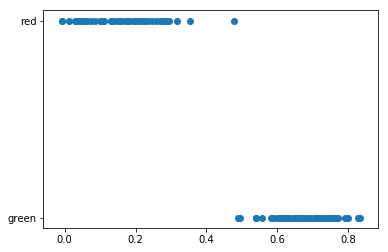

In [263]:
pos = [model.similarity(a, b) for a, b in posw]
neg = [model.similarity(a, b) for a, b in negw]
plt.scatter(pos + neg, ['green'] * len(pos) + ['red'] * len(neg))
plt.show()

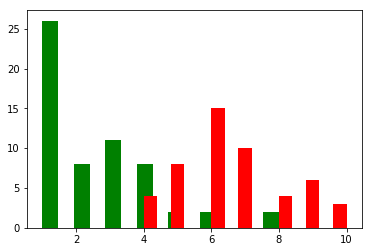

In [264]:
pos = [levenshtein_distance(a, b) for a, b in posw]
neg = [levenshtein_distance(a, b) for a, b in negw]
plt.hist(pos, bins=15, color='green')
plt.hist(neg, bins=15, color='red')
plt.show()

In [273]:
x

образование_r
дух_r
антарктида_r
урна_r
секрет_r
кадр_r
корабль_r
мост_r
область_r
жизнь_b
диск_b
покров_b
воздух_b
вилка_b
кран_b
нота_b
пушкин_b
танец_d
луна_w
америка_w
рулетка_w
косяк_w
спутник_w
жук_w
секция_w

In [274]:
bruteforce(x, 'r')[:10]

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[(2.5616063116448506,
  ('гидрография', 4),
  [антарктида_r, образование_r, область_r, корабль_r]),
 (2.1309297535714578, ('танкер', 3), [корабль_r, мост_r, антарктида_r]),
 (2.1309297535714578, ('специалист', 3), [образование_r, кадр_r, область_r]),
 (2.1309297535714578,
  ('саяно-алтайский', 3),
  [область_r, антарктида_r, образование_r]),
 (2.1309297535714578,
  ('республика::бурятия', 3),
  [область_r, образование_r, антарктида_r]),
 (2.1309297535714578, ('пролив', 3), [корабль_r, мост_r, антарктида_r]),
 (2.1309297535714578,
  ('прибайкалия', 3),
  [антарктида_r, область_r, образование_r]),
 (2.1309297535714578, ('парусник', 3), [корабль_r, антарктида_r, мост_r]),
 (2.1309297535714578, ('кильдин', 3), [антарктида_r, корабль_r, мост_r]),
 (2.1309297535714578,
  ('гидрография', 3),
  [антарктида_r, образование_r, область_r])]

In [275]:
query_move = do_move(x)
query_move

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


('гидрография', 4)

In [276]:
for i in range(query_move[1]):
    do_clear(x, do_guess(x, query_move[0]).word)

/home/kikos/anaconda3/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [277]:
x

образование_r_u
дух_r
антарктида_r_u
урна_r
секрет_r
кадр_r
корабль_r_u
мост_r
область_r_u
жизнь_b
диск_b
покров_b
воздух_b
вилка_b
кран_b
нота_b
пушкин_b
танец_d
луна_w
америка_w
рулетка_w
косяк_w
спутник_w
жук_w
секция_w